In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected

Input data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Params

In [13]:
num_inputs=784    #28x28 pixels
num_hid1=392
num_hid2=196
num_hid3=num_hid1
num_output=num_inputs
lr=0.00001
actf=tf.nn.relu

In [14]:
# setting params
num_epoch=5
batch_size=32
num_test_images=10

#### Model

In [5]:
X=tf.placeholder(tf.float32,shape=[None,num_inputs])
initializer=tf.variance_scaling_initializer()

w1=tf.Variable(initializer([num_inputs,num_hid1]),dtype=tf.float32)
w2=tf.Variable(initializer([num_hid1,num_hid2]),dtype=tf.float32)
w3=tf.Variable(initializer([num_hid2,num_hid3]),dtype=tf.float32)
w4=tf.Variable(initializer([num_hid3,num_output]),dtype=tf.float32)

b1=tf.Variable(tf.zeros(num_hid1))
b2=tf.Variable(tf.zeros(num_hid2))
b3=tf.Variable(tf.zeros(num_hid3))
b4=tf.Variable(tf.zeros(num_output))

hid_layer1=actf(tf.matmul(X,w1)+b1)
hid_layer2=actf(tf.matmul(hid_layer1,w2)+b2)
hid_layer3=actf(tf.matmul(hid_layer2,w3)+b3)
output_layer=actf(tf.matmul(hid_layer3,w4)+b4)

#### loss, opt

Practice

In [49]:
a = tf.constant(np.ones((100,2,2,1)))

In [50]:
b = tf.constant(2*np.ones((100,2,2,1)))

In [51]:
c = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(tf.subtract(b,a))
            , axis=(1,2)
            )
        )

In [61]:
d = tf.add(c, tf.multiply( tf.constant(0.1 ,tf.float64), c))

In [62]:
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(d)
    print(d.eval())

4.4


main

In [35]:
def loss_fn(ouput_layer, X):
    return tf.reduce_mean(tf.square(output_layer-X))

In [92]:
def dev_loss_fn(output_layer, X, batch_size, c_lambda):

    def rotate_opetation(imgs, oimgs):
        loss_list = []
        # rotate list
        angle_list = [i for i in range(5,360,15)]
        for angles in angle_list:
            rimgs = tf.contrib.image.rotate(
                oimgs,
                tf.constant(angles ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
            )
            loss_reconst = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(imgs-rimgs)
                , axis=(1,2)
                )
            )
            loss_list.append(loss_reconst)
        return loss_list
    
    with tf.variable_scope("gradient"):   
        # set shape
        outputs = tf.reshape(output_layer, [batch_size, 28,28,1])
        labels  = tf.reshape(X, [batch_size, 28,28,1])
        
        ### rotate for resoncstraction
        """
        argmax_theta | z(x) - z(R_theta x)|
        """
        loss_list = rotate_opetation(outputs, outputs)
        loss_reconst = tf.reduce_max(tf.stack(loss_list))
    
        ### rotate for image
        """
        argmin_theta | x - R_theta x|
        """
        loss_list = rotate_opetation(labels, outputs)
        loss_img = tf.reduce_min(tf.stack(loss_list))
    
        loss_reconst = tf.multiply(tf.constant(c_lambda ,dtype=tf.float32) , loss_reconst )
        return tf.add(loss_img ,loss_reconst)
        #return tf.add(loss_img , loss_reconst ) 

In [32]:
def rotate_inv_loss_fn(ouput_layer, X,
                       w1, w2,
                       b1, b2,
                       hid_layer2,
                       batch_size, c_lambda):
    """
    encs_layer : z(x_i)
    rencs_layer: z(Rx_i)
    """

    def rotate_opetation(imgs, oimgs):
        loss_list = []
        # rotate list
        angle_list = [i for i in range(5,360,15)]
        for angles in angle_list:
            rimgs = tf.contrib.image.rotate(
                oimgs,
                tf.constant(angles ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
            )
            loss_reconst = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(imgs-rimgs)
                , axis=(1,2)
                )
            )
            loss_list.append(loss_reconst)
        return loss_list
    
    with tf.variable_scope("gradient"):   
        # set shape
        outputs = tf.reshape(output_layer, [batch_size, 28,28,1])
        labels  = tf.reshape(X, [batch_size, 28,28,1])
        
        ### rotate for resoncstraction 
        """
        argmax_theta | z(x) - z(R_theta x)|
        z is output of bootleneck layer
        """
        #angle_list = [i for i in range(5,360,15)]
        #loss_list = []
        #for angles in angle_list:
        #    rlabels = tf.contrib.image.rotate(
        #        labels,
        #        tf.constant(angles ,dtype=tf.float32),
        #        interpolation='NEAREST',
        #        name=None
        #    )
        #    _hid_layer1=actf(tf.matmul(tf.reshape(rlabels, (batch_size,28*28)),w1)+b1)
        #    _hid_layer2=actf(tf.matmul(_hid_layer1,w2)+b2)
        #    loss_latent = tf.reduce_mean(
        #            tf.square(hid_layer2 - _hid_layer2)
        #    )
        #    loss_list.append(loss_latent)
        #loss_reconst = tf.math.log(tf.reduce_max(tf.stack(loss_list)))
    
        ### rotate for image
        """
        argmin_theta | x - R_theta x|
        """
        loss_list = rotate_opetation(labels, outputs)
        loss_img = tf.reduce_min(tf.stack(loss_list))
        return loss_img
        #loss_reconst = tf.multiply(tf.constant(c_lambda ,dtype=tf.float32) , loss_reconst )
        #return tf.add(loss_img ,loss_reconst)

In [35]:
def rotate_inv_loss_fn(output_layer, X,
                       w1, w2,
                       b1, b2,
                       hid_layer2,
                       batch_size, c_lambda):
    """
    encs_layer : z(x_i)
    rencs_layer: z(Rx_i)
    """
    def l2_loss_fn(oupu, X):
        return tf.reduce_mean(tf.square(output_layer-X))
    
    def rotate_opetation(imgs, oimgs):
        loss_list = []
        # rotate list
        angle_list = [i for i in range(5,360,15)]
        for angles in angle_list:
            rimgs = tf.contrib.image.rotate(
                oimgs,
                tf.constant(angles ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
            )
            loss_reconst = tf.reduce_mean(
                    tf.square(tf.reshape(imgs,(batch_size,28*28)) - tf.reshape(rimgs, (batch_size, 28*28)) )
                )
            loss_list.append(loss_reconst)
        return loss_list
    
    with tf.variable_scope("gradient"):   
        # set shape
        outputs = tf.reshape(output_layer, [batch_size, 28,28,1])
        labels  = tf.reshape(X, [batch_size, 28,28,1])
        
        ### rotate for resoncstraction 
        """
        argmax_theta | z(x) - z(R_theta x)|
        z is output of bootleneck layer
        """
        angle_list = [i for i in range(5,360,15)]
        loss_list = []
        for angles in angle_list:
            rlabels = tf.contrib.image.rotate(
                labels,
                tf.constant(angles ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
            )
            _hid_layer1=actf(tf.matmul(tf.reshape(rlabels, (batch_size,28*28)),w1)+b1)
            _hid_layer2=actf(tf.matmul(_hid_layer1,w2)+b2)
            loss_latent = tf.reduce_mean(
                    tf.square(hid_layer2 - _hid_layer2)
            )
            loss_list.append(loss_latent)
        loss_reconst = tf.reduce_max(tf.stack(loss_list))
        loss_reconst = tf.multiply(tf.constant(c_lambda ,dtype=tf.float32) , loss_reconst )
        
        ### rotate for image
        """
        argmin_theta | x - R_theta x|
        """
        loss_list = rotate_opetation(labels, outputs)
        loss_img = tf.reduce_min(tf.stack(loss_list))
        return loss_img
        #return loss_img , loss_reconst

In [31]:
[i for i in range(1,360,30)]

[1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331]

In [29]:
def dev_loss_fn(output_layer, X, batch_size, c_lambda):

    def rotate_opetation(imgs, oimgs):
        loss_list = []
        # rotate list
        angle_list = [i for i in range(1,360,30)]
        for angles in angle_list:
            rimgs = tf.contrib.image.rotate(
                oimgs,
                tf.constant(angles ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
            )
            loss_reconst = tf.reduce_mean(
                    tf.square(tf.reshape(imgs,(batch_size,28*28)) - tf.reshape(rimgs, (batch_size, 28*28)) )
                )
            loss_list.append(loss_reconst)
        return loss_list
    
    with tf.variable_scope("gradient"):   
        # set shape
        outputs = tf.reshape(output_layer, [batch_size, 28,28,1])
        labels  = tf.reshape(X, [batch_size, 28,28,1])
        
        ### rotate for image
        """
        argmin_theta | x - R_theta x|
        """
        loss_list = rotate_opetation(labels, outputs)
        loss_img = tf.reduce_min(tf.stack(loss_list))
    
        return loss_img 
        #return tf.add(loss_img , loss_reconst ) 

In [36]:
c_lambda=0.1
#loss = dev_loss_fn(output_layer, X, batch_size, c_lambda)
loss = rotate_inv_loss_fn(output_layer, X,
                       w1, w2,
                       b1, b2,
                       hid_layer2,
                       batch_size, c_lambda)

train_ops = tf.train.AdamOptimizer(lr).minimize(loss)

In [10]:
#loss= loss_fn(output_layer, X) # original

c_lambda = 0.5
loss_min, loss_max = rotate_inv_loss_fn(output_layer, X, 
                                          w1, w2,
                                          b1, b2,
                                          hid_layer2,
                                          batch_size, c_lambda)  # rotate invariant
#train_op_min=tf.train.AdamOptimizer(lr).minimize(loss_min)
#train_op_max=tf.train.AdamOptimizer(lr).minimize(-1 * loss_max)

train_ops = tf.train.AdamOptimizer(lr).minimize(loss_min)

# usually here
#optimizer=tf.train.AdamOptimizer(lr)
#train_ops=optimizer.minimize(loss)

----------------------------
### First Try 8/3
Loss function was different from our proposition. But left here for reference

#### Train c_lambda=1.0

epoch 0 loss 47.06494140625
epoch 1 loss 44.25304412841797
epoch 2 loss 48.30340576171875
epoch 3 loss 47.10863494873047
epoch 4 loss 46.93739700317383


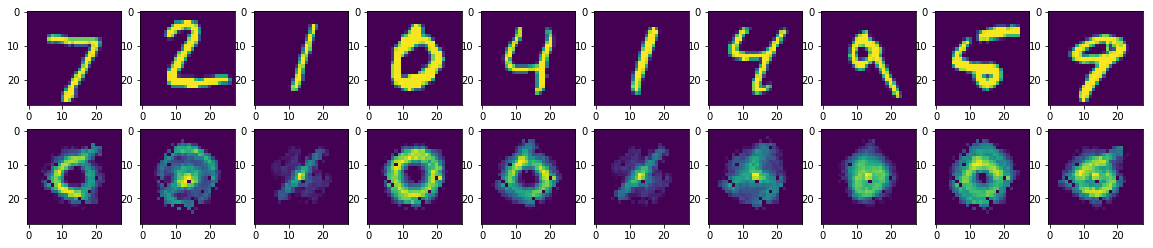

In [100]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

#### Train c_lambda=0.5

epoch 0 loss 41.868064880371094
epoch 1 loss 41.40913391113281
epoch 2 loss 40.64411544799805
epoch 3 loss 40.8916015625
epoch 4 loss 41.56822204589844


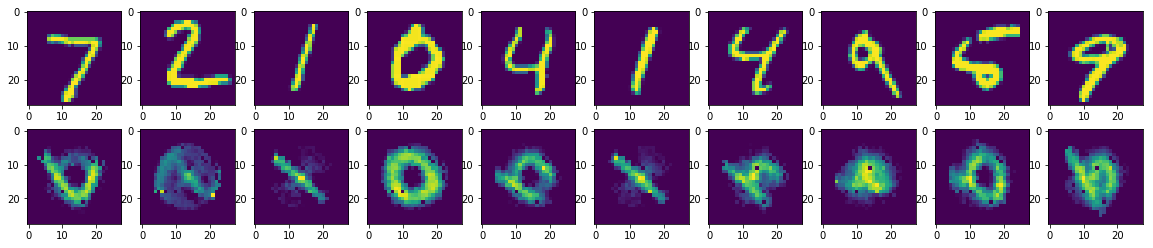

In [94]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

#### Train c_lambda=0.1

epoch 0 loss 38.01204299926758
epoch 1 loss 40.18955612182617
epoch 2 loss 35.367431640625
epoch 3 loss 32.09087371826172
epoch 4 loss 34.308074951171875


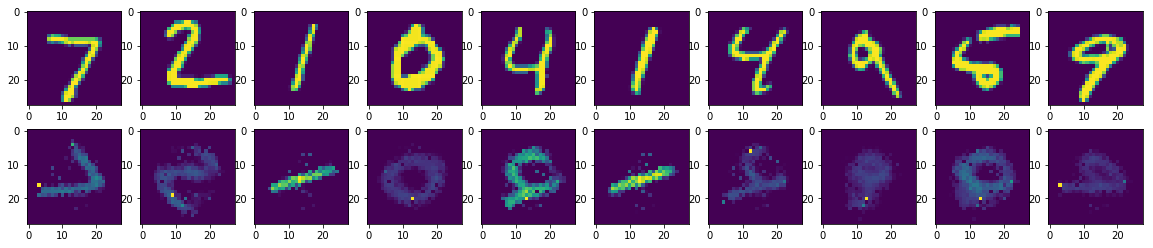

In [98]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

#### Train with loss : MSE

In [95]:
loss= loss_fn(output_layer, X) # original

optimizer=tf.train.AdamOptimizer(lr)
train_ops=optimizer.minimize(loss)

epoch 0 loss 0.02280101366341114
epoch 1 loss 0.019023597240447998
epoch 2 loss 0.017548151314258575
epoch 3 loss 0.017659759148955345
epoch 4 loss 0.01763537898659706


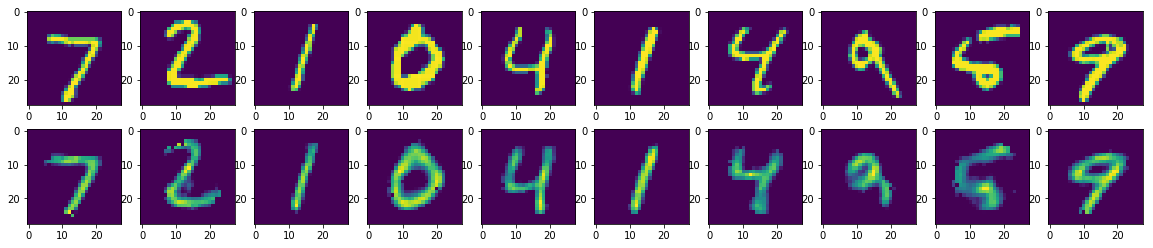

In [96]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

---------------------
### 8/8 Try 2

epoch 0 loss 4325973688320.0
epoch 1 loss 85563650605056.0
epoch 2 loss 426319292661760.0
epoch 3 loss 1216085630124032.0
epoch 4 loss 2753969805852672.0


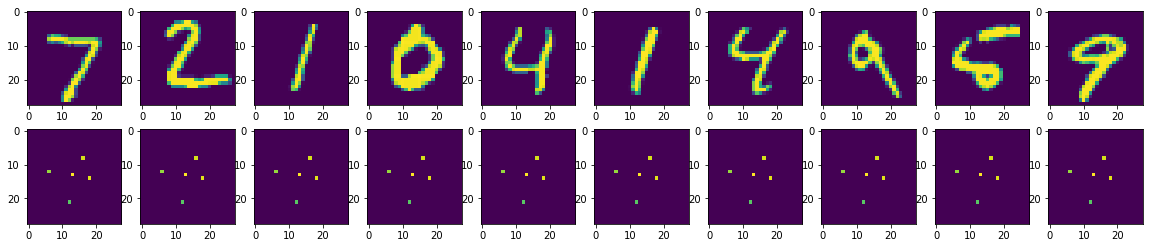

In [12]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss_min.eval(feed_dict={X:X_batch}) + loss_max.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

epoch 0 loss 0.05588246509432793
epoch 1 loss 0.10433000326156616
epoch 2 loss 0.11414806544780731
epoch 3 loss 0.11634209752082825
epoch 4 loss 0.10379833728075027


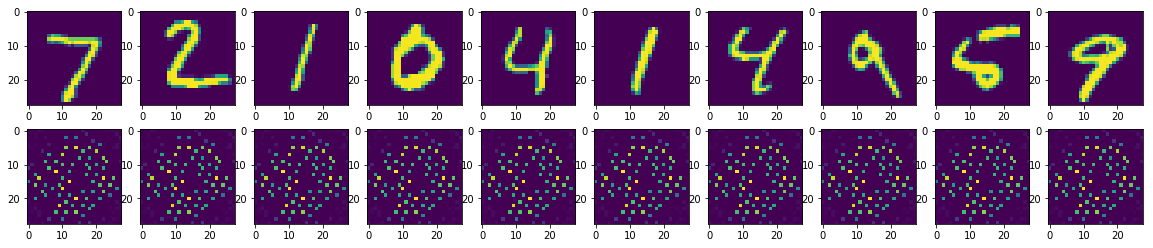

In [33]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch}) #+ loss_max.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

epoch 0 loss 0.05265839770436287
epoch 1 loss 0.12209399789571762
epoch 2 loss 0.10677359253168106
epoch 3 loss 0.11347859352827072
epoch 4 loss 0.11712000519037247


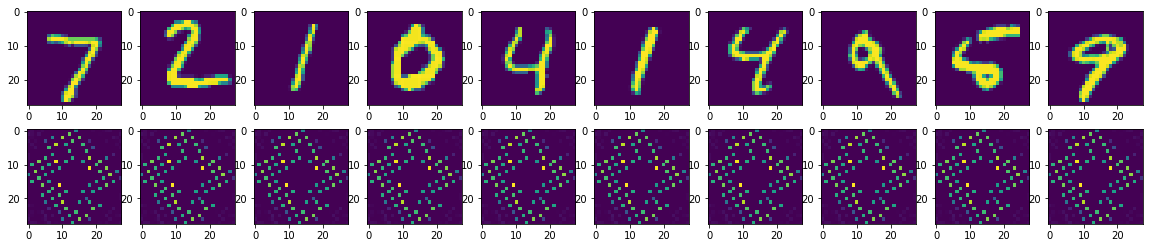

In [34]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

epoch 0 loss 15.732009887695312
epoch 1 loss 206735.390625
epoch 2 loss 18922282.0
epoch 3 loss 226609072.0
epoch 4 loss 1126710400.0


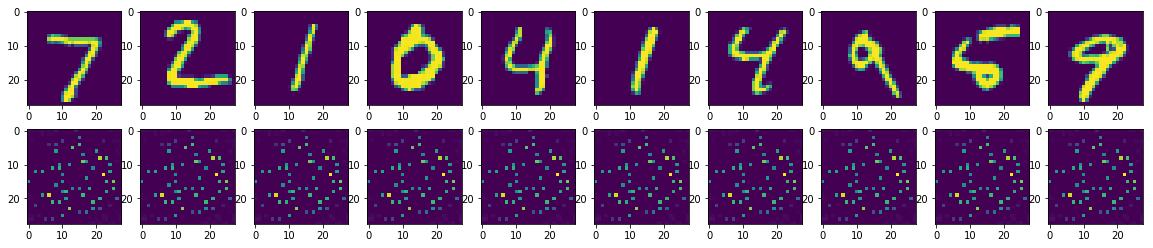

In [37]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))